# Exploring the Impact of Weather and Climate on Bicycle Traffic in Köln: A Comprehensive Report

This project report aims to analyze **the weather and climate conditions of Köln and its bicycle traffic** generated from several automatic counting stations throughout the city to determine if Köln is a suitable city for an enthusiastic cyclist to live in. The project is using two open data sources: [mobilithek](https://mobilithek.info/), which contains information on bicycle traffic in Köln, and [meteostat](https://meteostat.net/en/), which provides weather and climate data of Köln.

### Datasource1: Bicycle Traffic Data in Köln
* Source: [mobilithek](https://mobilithek.info/)
* Metadata URL: [https://mobilithek.info/offers/-2236641647976866002](https://mobilithek.info/offers/-2236641647976866002)
* Sample Data URL: [https://offenedaten-koeln.de/sites/default/files/Fahrrad_Zaehlstellen_Koeln_2016.csv](https://offenedaten-koeln.de/sites/default/files/Fahrrad_Zaehlstellen_Koeln_2016.csv)
* Data Type: CSV

This data source contains Köln's bicycle traffic generated from several [automatic counting stations](http://www.eco-public.com/ParcPublic/?id=677) throughout the city from 2009.

### Datasource2: Weather and Climate Data of Köln
* Source: [meteostat](https://meteostat.net/en/)
* Metadata URL: [https://dev.meteostat.net/bulk/monthly.html](https://dev.meteostat.net/bulk/monthly.html)
* Sample Data URL: [https://bulk.meteostat.net/v2/monthly/{station}.csv.gz](https://bulk.meteostat.net/v2/monthly/{station}.csv.gz), Station-id of Köln = '10513', 'D2968'
* Data Type: CSV

This data source will provide weather and climate data in Köln, including average air temperature, daily minimum and maximum air temperature, monthly precipitation total, maximum snow depth, average wind direction and speed, peak wind gust, average sea-level air pressure, and monthly sunshine total.

Now, the question that interests us is: **How does weather condition in Köln impact bicycle traffic throughout the year?**

### Project Structure: ETL Pipeline

The project follows a structured ETL (Extract, Transform, Load) pipeline approach, encompassing various directories and modules with specific functionalities. The `main.py` serves as the entry point for running the pipeline using the command `pdm run main.py`, resulting in the generation of the final dataset stored in an SQLite database.

```bash
project/
├── config/                     # Configuration files and settings
│   ├── __init__.py
│   ├── config_var.py           # Configuration variables
│   └── source_info.json        # Source information
├── data/                       # Data directory
│   ├── processed/              # Processed data
│   └── raw/                    # Raw data
├── etl/                        # ETL (Extract, Transform, Load) pipeline modules
│   ├── __init__.py
│   ├── extract/                # Extraction module
│   │   ├── __init__.py
│   │   └── data_extractor.py   # Data extraction logic
│   ├──transform/              # Transformation module
│   │   ├── __init__.py
│   │   └── data_transformer.py # Data transformation logic
│   └── load/                   # Loading module
│       ├── __init__.py
│       └── data_loader.py      # Data loading logic
├── pipelines/                  # Data pipeline modules
│   ├── __init__.py
│   └── data_pipeline.py        # ETL data pipeline implementation
├── utils/                      # Utility modules
│   ├── __init__.py
│   └── service_factory.py      # Service factory utility
├── tests/                      # Test modules
│   ├── __init__.py
│   ├── test_component.py       # Test cases for component testing
│   ├── test_pipeline.py        # Test cases for system testing
│   └── transformed_data.pkl    # Original transformed data for testing purposes
├── main.py                     # Entry point of the project
├── tests.sh                    # Bash script for running all the test cases
├── exploration.ipynb           # Notebook for data exploration
├── report.ipynb                # Notebook for final project report
└── project-plan.md             # Project plan and documentation
```

### Install Dependencies

To install the dependencies for this project, we will be using [PDM](https://pdm.fming.dev/latest/), which is a modern Python package and dependency manager supporting the latest PEP standards. To install the dependencies using PDM, follow these steps:
- Install PDM on the system. We can install it by following the instructions provided in the [PDM documentation](https://pdm.fming.dev/latest/#installation).
- Once PDM is installed, navigate to the project directory in terminal and run the following command to install the dependencies specified in the `pyproject.toml` file:
    ```bash
    pdm install
    ```

In [53]:
%pip install numpy
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



### Import Packages

In [54]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

This section involves retrieving the data from a sqlite database and loading it into two Pandas DataFrames. And then merge these together for creating comprehensive report.

In [55]:
conn = sqlite3.connect("fau_data_engineering_ss23.sqlite")
bicycle_traffic_df = pd.read_sql_query(f"SELECT * FROM mobilithek_bicycle_traffic", conn)
weather_data_df = pd.read_sql_query(f"SELECT * FROM meteostat_weather_data", conn)
conn.close()

In [56]:
bicycle_traffic_df.head()

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
0,January-2009,46319,24610,59344,78727,0,0,0,0,0,0,0,0,0,0,0,0,0
1,February-2009,47764,29590,62228,91075,0,0,0,0,0,0,0,0,0,0,0,0,0
2,March-2009,68778,44312,84760,107262,0,0,0,0,0,0,0,0,0,0,0,0,0
3,April-2009,78619,55086,95298,146057,0,0,0,0,0,0,0,0,0,0,0,0,0
4,May-2009,79369,52725,102051,159319,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
# Convert None to NaN in expected_data_t2
weather_data_df = weather_data_df.where(pd.notnull(weather_data_df), np.nan)
# Convert dtype of tsun_D2968 column from object to float
weather_data_df["tsun_D2968"] = weather_data_df["tsun_D2968"].astype(float)
weather_data_df.head()

,date,tavg_10513,tmin_10513,tmax_10513,prcp_10513,wspd_10513,pres_10513,tsun_10513,tavg_D2968,tmin_D2968,tmax_D2968,prcp_D2968,wspd_D2968,pres_D2968,tsun_D2968
0,January-2009,-0.5,-4.4,2.9,26.0,11.1,1015.2,5340.0,0.4,-2.6,3.4,36.9,NaN,NaN,NaN
1,February-2009,3.1,0.0,6.2,70.0,12.3,1014.5,1800.0,3.8,1.2,6.4,71.0,NaN,NaN,NaN
2,March-2009,6.1,1.7,10.5,104.0,12.6,1014.9,5460.0,6.9,3.3,10.6,100.0,NaN,NaN,NaN
3,April-2009,13.3,6.8,19.1,78.0,10.0,1014.0,11220.0,14.0,8.8,19.0,59.2,NaN,NaN,NaN
4,May-2009,14.5,8.0,20.1,63.0,10.8,1019.2,11940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Exploration

This section focuses on exploring two sets of data further: [Mobilithek Bicycle Traffic Data in Köln](https://mobilithek.info/offers/-2236641647976866002) and [Meteostat Weather and Climate Data of Köln](https://dev.meteostat.net/bulk/monthly.html).

#### Exploration of the Mobilithek Bicycle Traffic Data in Köln

In [58]:
bicycle_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   168 non-null    object
 1   Deutzer Brücke         168 non-null    int64 
 2   Hohenzollernbrücke     168 non-null    int64 
 3   Neumarkt               168 non-null    int64 
 4   Zülpicher Straße       168 non-null    int64 
 5   Bonner Straße          168 non-null    int64 
 6   Venloer Straße         168 non-null    int64 
 7   A.-Schütte-Allee       168 non-null    int64 
 8   Vorgebirgspark         168 non-null    int64 
 9   A.-Silbermann-Weg      168 non-null    int64 
 10  Stadtwald              168 non-null    int64 
 11  Niederländer Ufer      168 non-null    int64 
 12  Vorgebirgswall         168 non-null    int64 
 13  Universitäts-straße    168 non-null    int64 
 14  Rodenkirchener Brücke  168 non-null    int64 
 15  Severinsbrücke         

Now, let's examine the date range of the 'Bicycle Traffic Data in Köln' to determine the available data period, starting from the minimum date and ending at the maximum date.

In [59]:
date_df = pd.to_datetime(bicycle_traffic_df['Date'], format='%B-%Y')
min_date = date_df.min().strftime('%B-%Y')
max_date = date_df.max().strftime('%B-%Y')
f"Date Range of the Bicycle Traffic Data in Köln: {min_date} to {max_date}"

'Date Range of the Bicycle Traffic Data in Köln: January-2009 to December-2022'

In [60]:
bicycle_traffic_df.head(6)

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
0,January-2009,46319,24610,59344,78727,0,0,0,0,0,0,0,0,0,0,0,0,0
1,February-2009,47764,29590,62228,91075,0,0,0,0,0,0,0,0,0,0,0,0,0
2,March-2009,68778,44312,84760,107262,0,0,0,0,0,0,0,0,0,0,0,0,0
3,April-2009,78619,55086,95298,146057,0,0,0,0,0,0,0,0,0,0,0,0,0
4,May-2009,79369,52725,102051,159319,0,0,0,0,0,0,0,0,0,0,0,0,0
5,June-2009,85576,51538,131255,160123,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
bicycle_traffic_df.tail(6)

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
162,July-2022,160142,78793,144518,155971,83698,181380,82110,35634,94880,82634,92596,89681,90651,69970,50351,104689,95068
163,August-2022,199040,104883,161798,174193,99881,207493,98258,45461,113437,116920,113372,124947,99332,84308,65845,128545,112127
164,September-2022,159829,79025,137943,163504,85979,178292,69677,34505,84756,78143,77222,100410,100228,55764,54330,105910,95742
165,October-2022,152882,75197,136711,172506,85703,189374,68128,31347,90212,75335,73277,96018,176722,51947,52062,104598,94887
166,November-2022,135685,69464,122413,162549,77491,169261,48256,28750,75998,65878,57586,93465,176539,41001,47036,99518,93621
167,December-2022,84232,43723,90147,105479,59919,121938,26591,18024,47965,32779,31445,62247,111549,20481,27754,70152,75571


By examining the head and tail of the Mobilithek Bicycle Traffic Data in Köln, we can observe that initially not all counting stations recorded bicycle traffic counts. Hence, we can verify the number of counting stations based on the date.

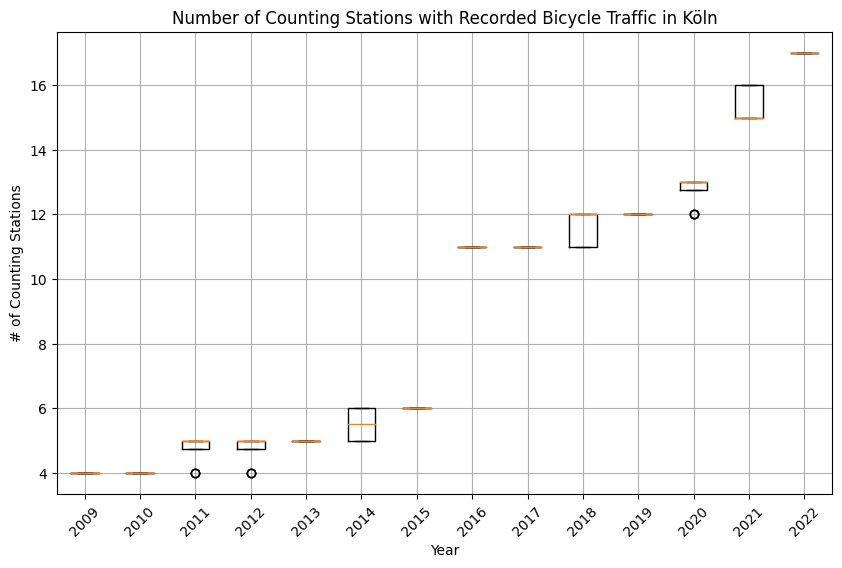

In [62]:
# Calculate the stations count for each year
counting_stations_df = pd.DataFrame({'Date': bicycle_traffic_df['Date']})
counting_stations_df['Counting Stations'] = (bicycle_traffic_df.iloc[:, 1:] != 0).sum(axis=1)

# Extract the year from the date column
counting_stations_df['Year'] = counting_stations_df['Date'].str.split('-').str[1]

# Group the data by year
grouped_data = counting_stations_df.groupby('Year')['Counting Stations'].apply(list)

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the box plot
plt.boxplot(grouped_data.values)

# Customize the plot
plt.title('Number of Counting Stations with Recorded Bicycle Traffic in Köln')
plt.xlabel('Year')
plt.ylabel('# of Counting Stations')
plt.grid(True)
# Set the x-axis labels to show only the year
plt.xticks(range(1, len(grouped_data) + 1), grouped_data.index, rotation=45)

# Show the plot
plt.show()

#### Exploration of the Meteostat Weather and Climate Data of Köln

Station Details of Köln:
- Station ID: 10513, Station Name: Köln-Bonn Airport, Station Region: NW
- Station ID: D2968, Station Name: Köln-Stammheim, Station Region: NW

In [63]:
weather_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        168 non-null    object 
 1   tavg_10513  168 non-null    float64
 2   tmin_10513  168 non-null    float64
 3   tmax_10513  168 non-null    float64
 4   prcp_10513  168 non-null    float64
 5   wspd_10513  168 non-null    float64
 6   pres_10513  168 non-null    float64
 7   tsun_10513  168 non-null    float64
 8   tavg_D2968  166 non-null    float64
 9   tmin_D2968  166 non-null    float64
 10  tmax_D2968  166 non-null    float64
 11  prcp_D2968  164 non-null    float64
 12  wspd_D2968  21 non-null     float64
 13  pres_D2968  21 non-null     float64
 14  tsun_D2968  0 non-null      float64
dtypes: float64(14), object(1)
memory usage: 19.8+ KB


Now, let's examine the date range of the 'Weather and Climate Data of Köln' to determine the available data period, starting from the minimum date and ending at the maximum date.

In [64]:
date_df = pd.to_datetime(weather_data_df['date'], format='%B-%Y')
min_date = date_df.min().strftime('%B-%Y')
max_date = date_df.max().strftime('%B-%Y')
f"Date Range of the Weather and Climate Data of Köln: {min_date} to {max_date}"

'Date Range of the Weather and Climate Data of Köln: January-2009 to December-2022'

Now, examining the 'Weather and Climate Data of Köln', it is apparent that the dataset contains a significant number of `null` values. Visualizing these `null` values allows us to assess their severity and identify columns that should be excluded from our reports.

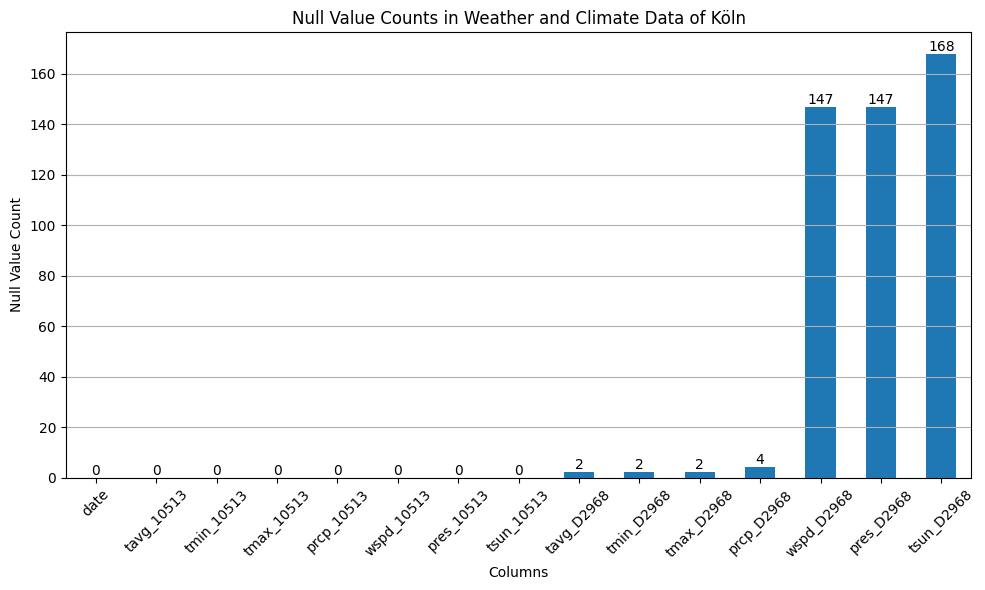

In [65]:
# Count the number of null values in each column
null_counts = weather_data_df.isnull().sum()

# Create a bar plot of null value counts
plt.figure(figsize=(10, 6))
ax = null_counts.plot(kind='bar')

plt.title('Null Value Counts in Weather and Climate Data of Köln')
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add text annotations for null count above each bar
for i, count in enumerate(null_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Exploration Summary